In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans

In [112]:
load = pd.read_csv('../Data/load.csv')
prices = pd.read_csv('../Data/prices.csv')
res_gen = pd.read_csv('../Data/res_gen.csv')
#residual_generation = pd.read_csv('../Data/residual_generation.csv')
industrial_demand = pd.read_csv('../Data/industrial_demand.csv')

#merge them all on date
data = pd.merge(load, prices, on='date')
data = pd.merge(data, res_gen, on='date')
#data = pd.merge(data, residual_generation, on='date')
data = pd.merge(data, industrial_demand, on='date')

#drop price_FRA
data = data.drop(columns=['price_FRA'])
help_data = pd.DataFrame()
help_data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

#drop all columns without GER in the name
data = data[data.columns[data.columns.str.contains('GER')]]
data['date'] = help_data['date']


data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['hour'] = data['date'].dt.hour
data['weekday'] = data['date'].dt.weekday

#replace n/e with np.NaN
data = data.replace('n/e', np.NaN)
data.isna().sum()

#save to csv
data.to_csv('data.csv', index=False)

# Descriptive analysis

## Load

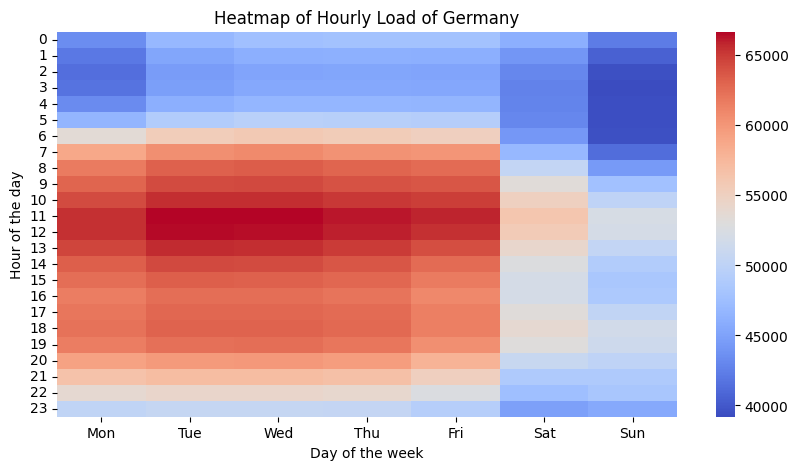

In [113]:
load_pivot = data.pivot_table(index='hour', columns='weekday', values='load_GER', aggfunc='mean')

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(load_pivot, cmap='coolwarm', ax=ax)

ax.set_title('Heatmap of Hourly Load of Germany')
ax.set_xlabel('Day of the week')
ax.set_ylabel('Hour of the day')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

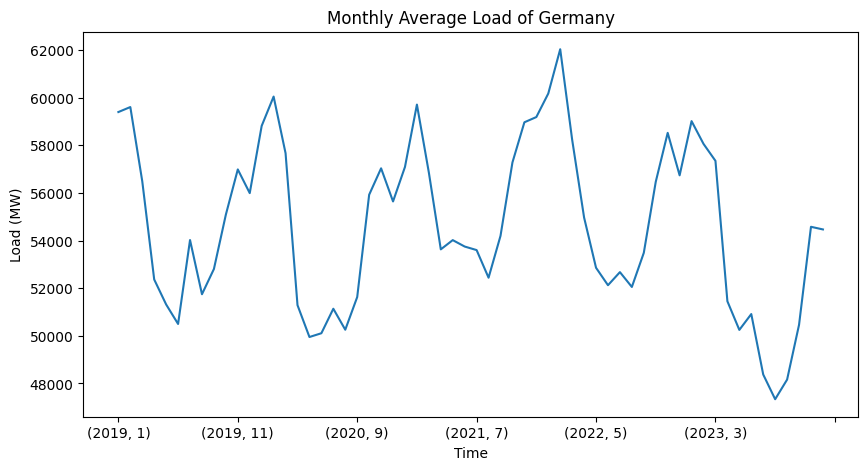

In [114]:
#group data to a yearly and monthly level
yearly_monthly_data = data.groupby(['year', 'month']).mean()

#plot the monthly average load
fig, ax = plt.subplots(figsize=(10, 5))
yearly_monthly_data['load_GER'].plot(ax=ax)
ax.set_title('Monthly Average Load of Germany')
ax.set_xlabel('Time')
ax.set_ylabel('Load (MW)')
plt.show()

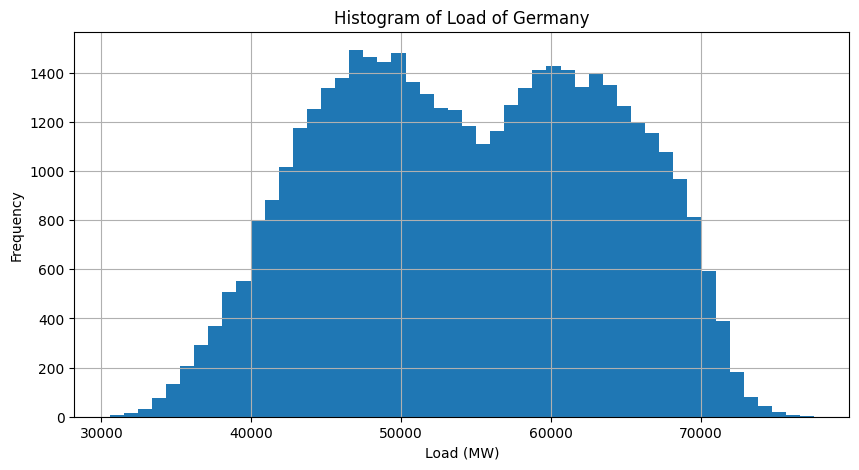

In [115]:
#make histogram of the load
fig, ax = plt.subplots(figsize=(10, 5))
data['load_GER'].hist(ax=ax, bins=50)
ax.set_title('Histogram of Load of Germany')
ax.set_xlabel('Load (MW)')
ax.set_ylabel('Frequency')
plt.show()

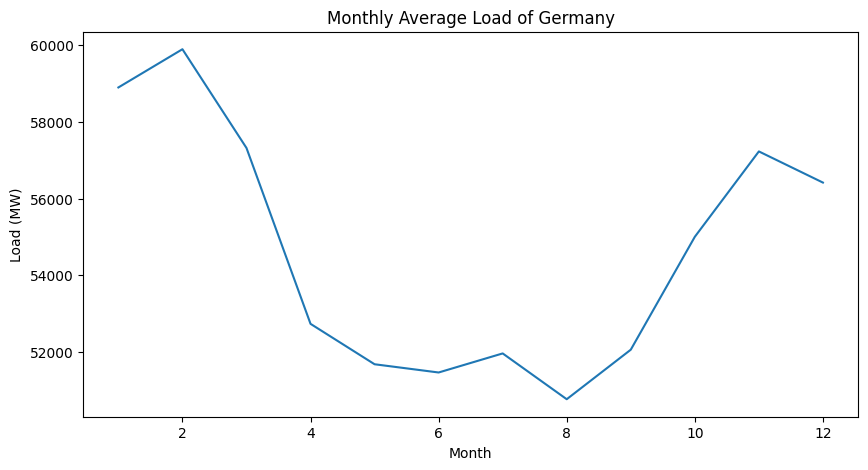

In [116]:
#group data to monthly level
monthly_data = data.groupby(['month']).mean()

#plot the monthly average load
fig, ax = plt.subplots(figsize=(10, 5))
monthly_data['load_GER'].plot(ax=ax)
ax.set_title('Monthly Average Load of Germany')
ax.set_xlabel('Month')
ax.set_ylabel('Load (MW)')
plt.show()

## Renewable generation

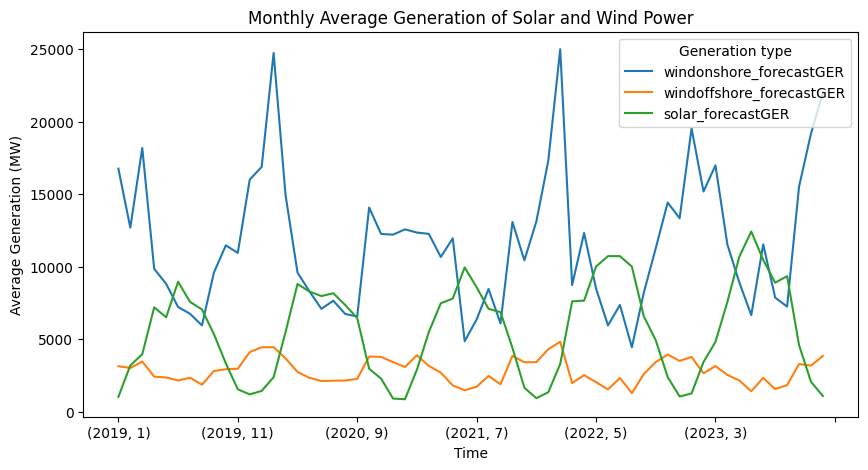

In [117]:
#plot the monthly average load
fig, ax = plt.subplots(figsize=(10, 5))
yearly_monthly_data['windonshore_forecastGER'].plot(ax=ax)
yearly_monthly_data['windoffshore_forecastGER'].plot(ax=ax)
yearly_monthly_data['solar_forecastGER'].plot(ax=ax)
ax.set_title('Monthly Average Generation of Solar and Wind Power')
ax.set_xlabel('Time')
ax.set_ylabel('Average Generation (MW)')
plt.legend(title='Generation type')
plt.show()

## Prices and correlations

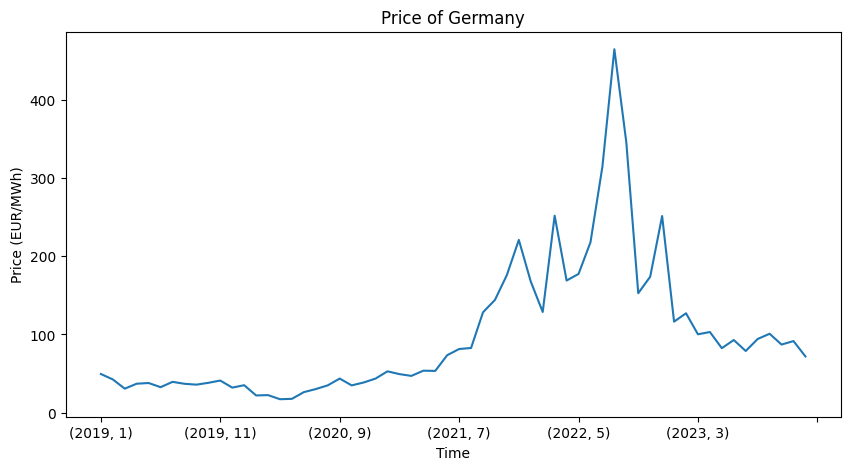

In [118]:
# plot prices
fig, ax = plt.subplots(figsize=(10, 5))
yearly_monthly_data['price_GER'].plot(ax=ax)
ax.set_title('Price of Germany')
ax.set_xlabel('Time')
ax.set_ylabel('Price (EUR/MWh)')
plt.show()

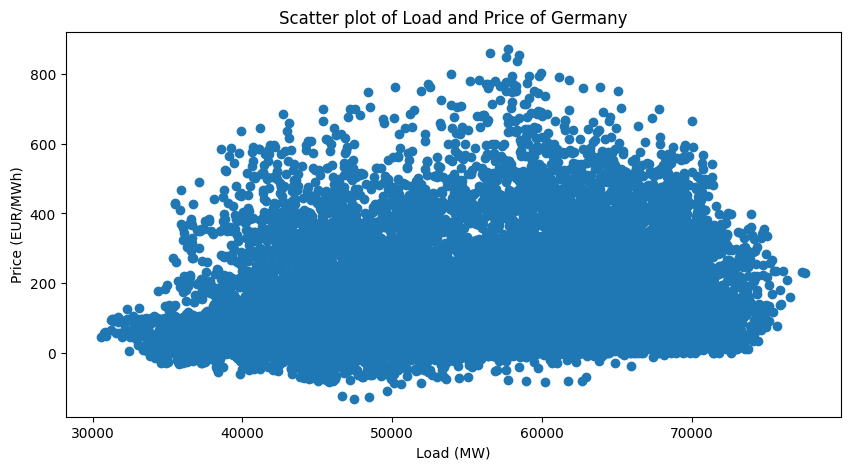

In [119]:
#scatter plot for load and price
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(data['load_GER'], data['price_GER'])
ax.set_title('Scatter plot of Load and Price of Germany')
ax.set_xlabel('Load (MW)')
ax.set_ylabel('Price (EUR/MWh)')
plt.show()

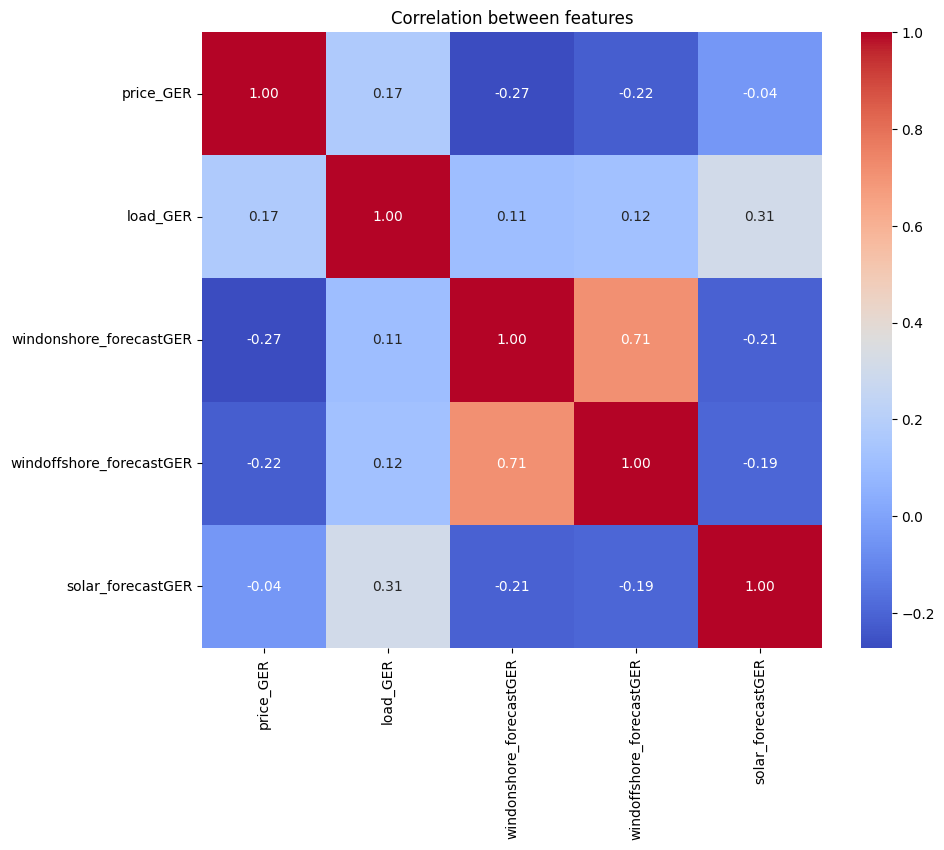

In [120]:
# Correlation Heatmap Between Load and Price
data_corr = data[['price_GER', 'load_GER', 'windonshore_forecastGER', 'windoffshore_forecastGER', 'solar_forecastGER']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation between features')
plt.show()

# Action plan generation

In [121]:
# create a df with one column for each hour and one row for each day
prices_df = data[['price_GER', 'date', 'hour', 'day']].copy()
# drop time from date column
prices_df['date'] = prices_df['date'].dt.date
#prices_df['date'] = pd.to_datetime(prices_df['date'])

prices_tab = prices_df.pivot(index='date',columns='hour', values='price_GER')
prices_tab = prices_tab.dropna()

# Make sure that each rows has a mean of 0 and a standard deviation of 1
prices_tab = prices_tab.apply(lambda x: (x - x.mean()) / x.std(), axis=1)
prices_df = pd.DataFrame(prices_tab, index=prices_tab.index, columns=prices_tab.columns)
prices_df

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,2.835846,1.249126,0.018874,-0.488007,-0.270648,-0.717538,-1.126173,-0.936636,-0.055028,-0.176749,...,0.373604,0.370995,0.544883,1.161313,0.379690,-0.058506,-0.233262,-1.793900,-0.049811,-2.141674
2019-01-02,-1.418533,-1.713030,-1.769545,-1.690853,-1.784806,-1.331257,-0.618265,0.274526,0.528008,0.591915,...,0.565684,0.661783,0.717583,0.739998,0.862328,0.863043,0.764798,0.708760,0.696598,0.592392
2019-01-03,-1.550323,-1.308449,-1.265519,-1.436192,-1.448757,-1.235154,-0.695911,-0.517909,0.541730,0.242267,...,0.787792,1.051654,1.119714,1.239081,1.001395,1.229657,1.116573,0.419222,-0.418437,-0.810042
2019-01-04,0.154060,-0.526058,-0.533573,-0.557997,-0.546724,-0.563633,-0.060121,1.016418,1.102842,1.053994,...,0.281817,0.334422,0.503512,0.892419,0.787208,0.371998,-0.625633,-0.841692,-1.117872,-3.475738
2019-01-05,-1.067491,-1.191839,-1.261697,-1.407002,-1.663381,-1.403509,-1.315488,-0.937555,-0.387771,-0.120214,...,0.680360,0.771176,1.008694,1.029651,1.359382,1.205694,0.738343,0.678963,0.642637,0.543438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,-0.480957,-0.685443,-0.881562,-0.877480,-0.816869,-0.878705,-0.802890,-0.410550,-0.539323,-0.558302,...,-0.665749,-0.359632,1.121872,1.410030,1.422989,1.420030,1.426255,1.418092,1.416459,1.317583
2023-12-27,-1.330084,-1.330324,-1.393328,-1.401369,-1.456932,-0.815609,-0.041798,1.354735,1.341055,1.353535,...,0.092851,0.096571,0.683411,1.291131,1.223447,0.479877,0.023487,-0.214609,-0.497828,-1.139631
2023-12-28,-1.115823,-1.191237,-1.196248,-1.256379,-1.247610,-1.176831,-0.993808,0.080780,0.483656,0.631603,...,0.397093,0.880770,1.080079,2.000707,1.770205,1.406163,0.288231,-0.181165,-0.368573,-1.048928


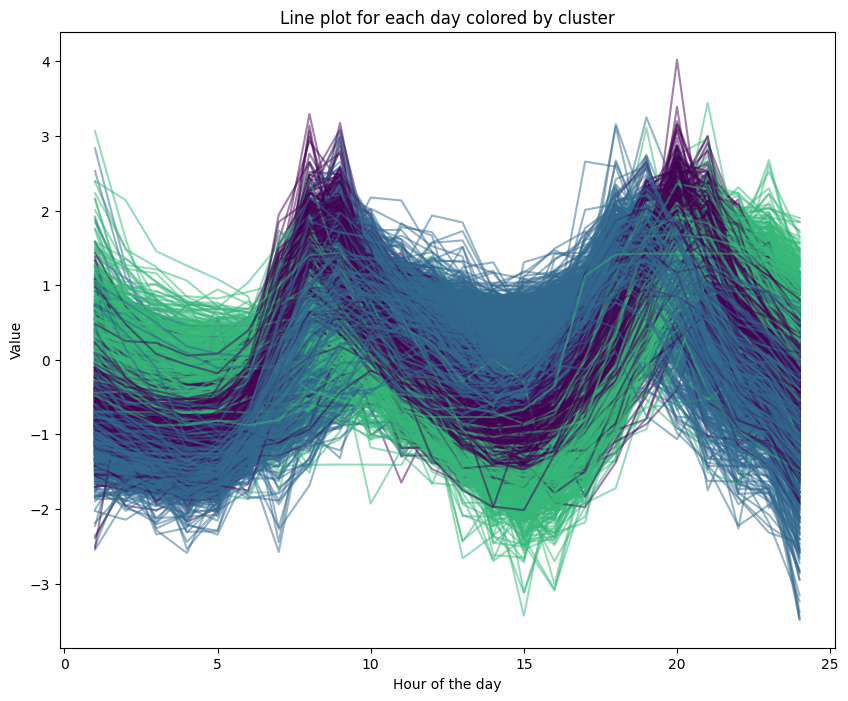

In [122]:
n_clusters=3

kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=100, max_iter=1000)
kmeans.fit(prices_df.iloc[:, :24])
prices_df['cluster'] = kmeans.labels_

# Assuming the columns representing hours are named as 'H1', 'H2', ..., 'H24'
hours = range(1, 25)

plt.figure(figsize=(10, 8))

# Plot a line for each day
for i in range(prices_df.shape[0]):
    plt.plot(hours, prices_df.iloc[i, :24], color=plt.cm.viridis(prices_df.iloc[i, -1]/3), alpha=0.5)

plt.xlabel('Hour of the day')
plt.ylabel('Value')
plt.title('Line plot for each day colored by cluster')
plt.show()

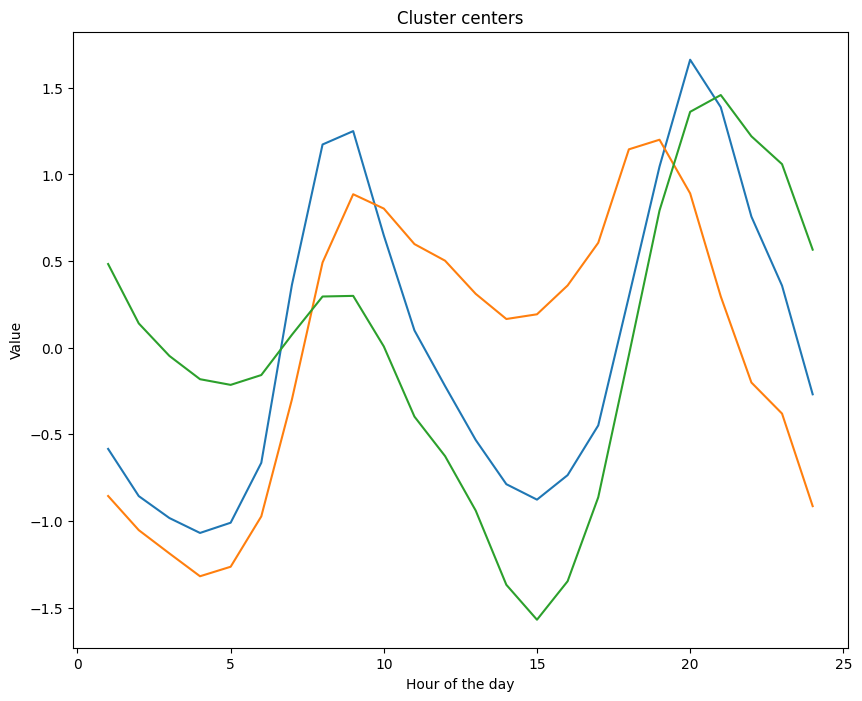

In [123]:
#plot kmeans.cluster_centers_
plt.figure(figsize=(10, 8))
plt.plot(hours, kmeans.cluster_centers_.T)
plt.xlabel('Hour of the day')
plt.ylabel('Value')
plt.title('Cluster centers')
plt.show()

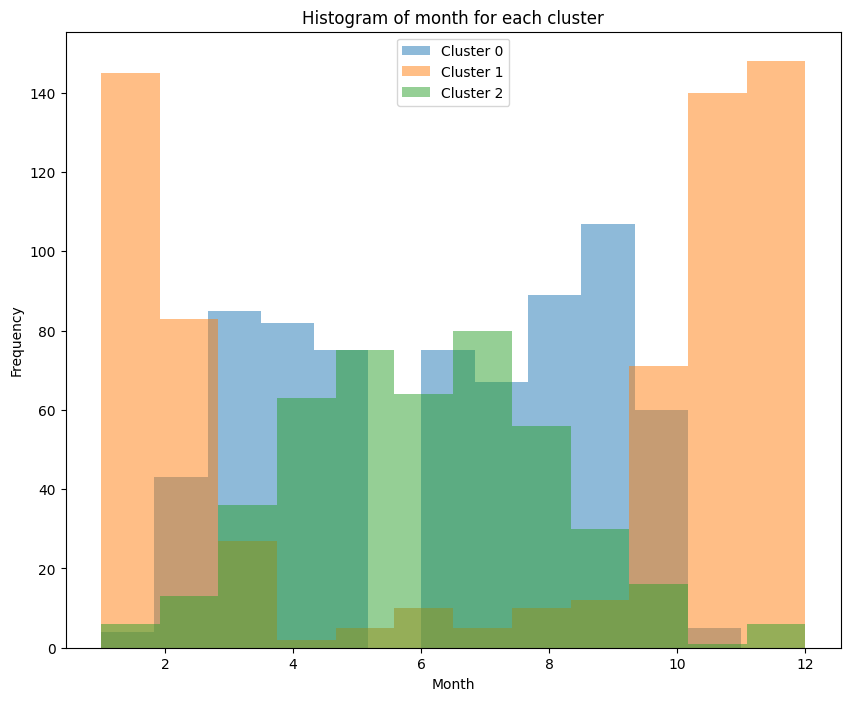

In [124]:
prices_df['month'] = pd.to_datetime(prices_df.index).month
prices_df['weekday'] = pd.to_datetime(prices_df.index).weekday

# make a histogram for each cluster for the month column and weekday column
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.hist(prices_df[prices_df['cluster'] == i]['month'], alpha=0.5, label='Cluster {}'.format(i), bins=12)
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Histogram of month for each cluster')
plt.legend()
plt.show()

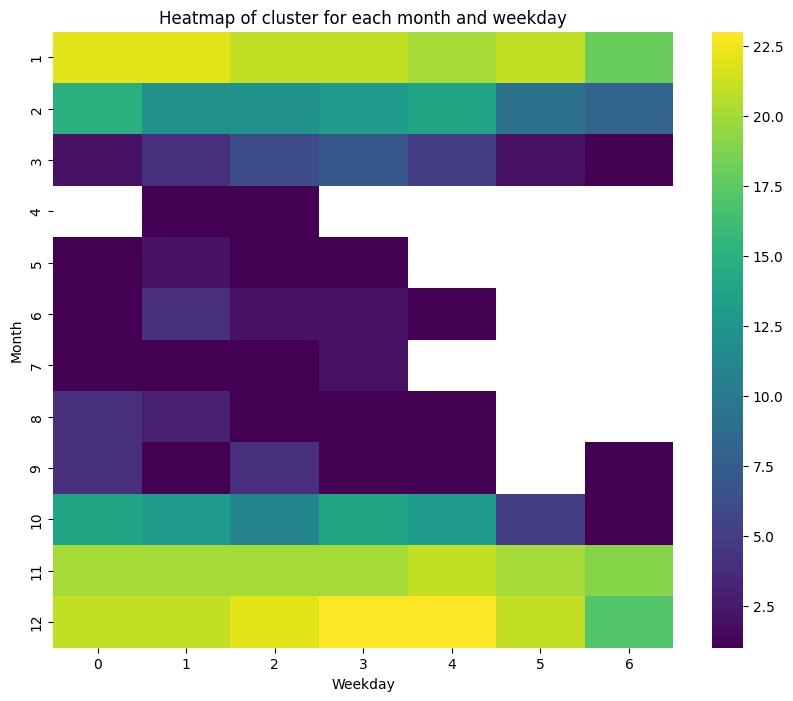

In [125]:
# make a sns heatmap with weekday and month on the x and y axis and the cluster as the color
heatmap_data = prices_df[prices_df['cluster'] == 1].pivot_table(index='month', columns='weekday', values='cluster', aggfunc='count')
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='viridis')
plt.xlabel('Weekday')
plt.ylabel('Month')
plt.title('Heatmap of cluster for each month and weekday')
plt.show()

0.1256797723561696
-0.02638019502414643
-0.015749189565169693


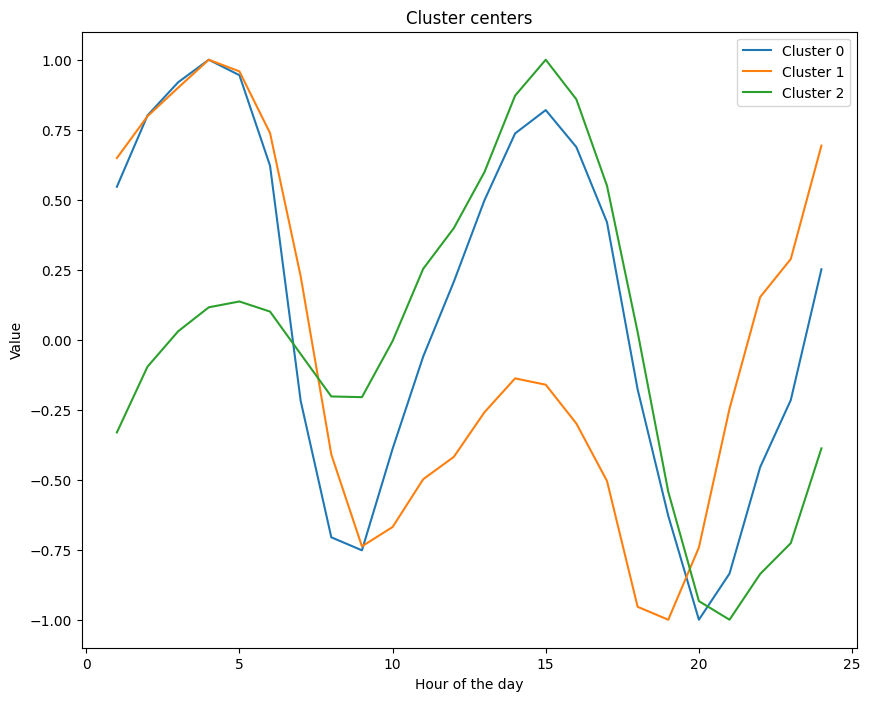

In [126]:
# invert the centroids
centroids = kmeans.cluster_centers_*-1
#divide positive values by max positive value and negative values by max negative value
for i in range(n_clusters):
    max_pos = centroids[i][centroids[i]>0].max()
    max_neg = centroids[i][centroids[i]<0].min()*-1
    centroids[i][centroids[i]>0] = centroids[i][centroids[i]>0]/max_pos
    centroids[i][centroids[i]<0] = centroids[i][centroids[i]<0]/max_neg
    print(centroids[i].mean())

plt.figure(figsize=(10, 8))
plt.plot(hours, centroids.T)
plt.xlabel('Hour of the day')
plt.ylabel('Value')
plt.title('Cluster centers')
plt.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.show()

In [127]:
action_4 = centroids[0]
action_4[action_4>0] = 1
action_4[action_4<0] = -1

action_5 = centroids[1]
action_5[action_5>0] = 1
action_5[action_5<0] = -1

action_6 = centroids[2]
action_6[action_6>0] = 1
action_6[action_6<0] = -1

action_6

array([-1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.])

In [128]:
#make a dictonary with all the action plans
action_plans = {
    0: centroids[0],
    1: centroids[1],
    2: centroids[2],
    3: [0*24],
    4: action_4,
    5: action_5,
    6: action_6
}